In [1]:
!pip install tensorflow --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
df = yf.download("TATAMOTORS.NS", start="2024-01-01", end="2024-12-31")
data = df[["Close"]].dropna()
df

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS,TATAMOTORS.NS
Date,,,,,
2024-01-01,781.448975,789.455255,772.009526,775.913817,12570717
2024-01-02,775.320801,794.693912,769.983280,791.234423,13791090
2024-01-03,772.404968,780.855993,767.265145,776.951701,8559060
2024-01-04,786.539429,792.519390,782.140924,788.763386,14298444
2024-01-05,781.794983,796.571953,777.989509,789.751794,11091198
...,...,...,...,...,...
2024-12-23,716.043579,728.139592,711.581940,727.445547,9653868
2024-12-24,729.825073,738.946660,716.341031,717.332506,12553555


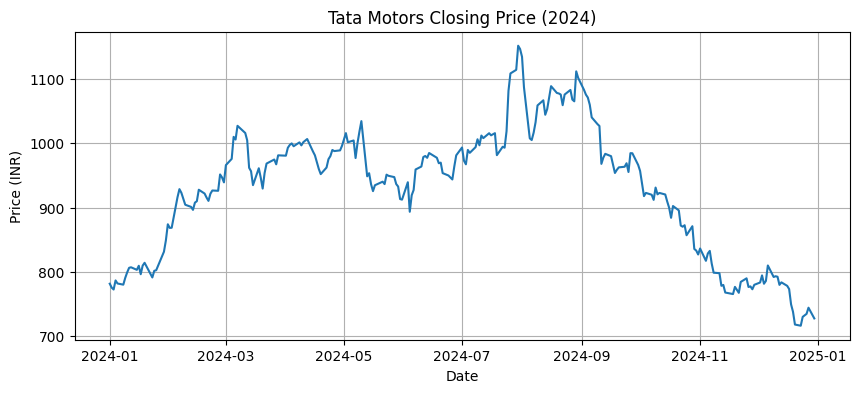

In [4]:
# Plot raw closing price
plt.figure(figsize=(10, 4))
plt.plot(data['Close'])
plt.title("Tata Motors Closing Price (2024)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

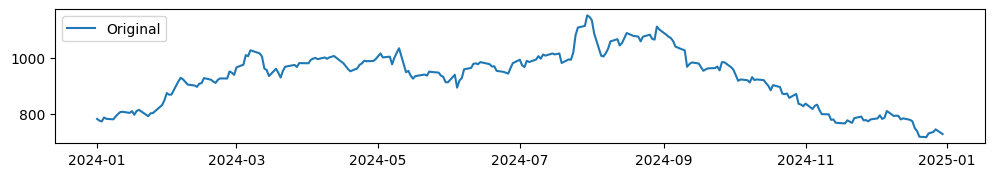

In [5]:
# 2. Decomposition (ETS)
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['Close'], label='Original')
plt.legend(loc='upper left')
plt.show()

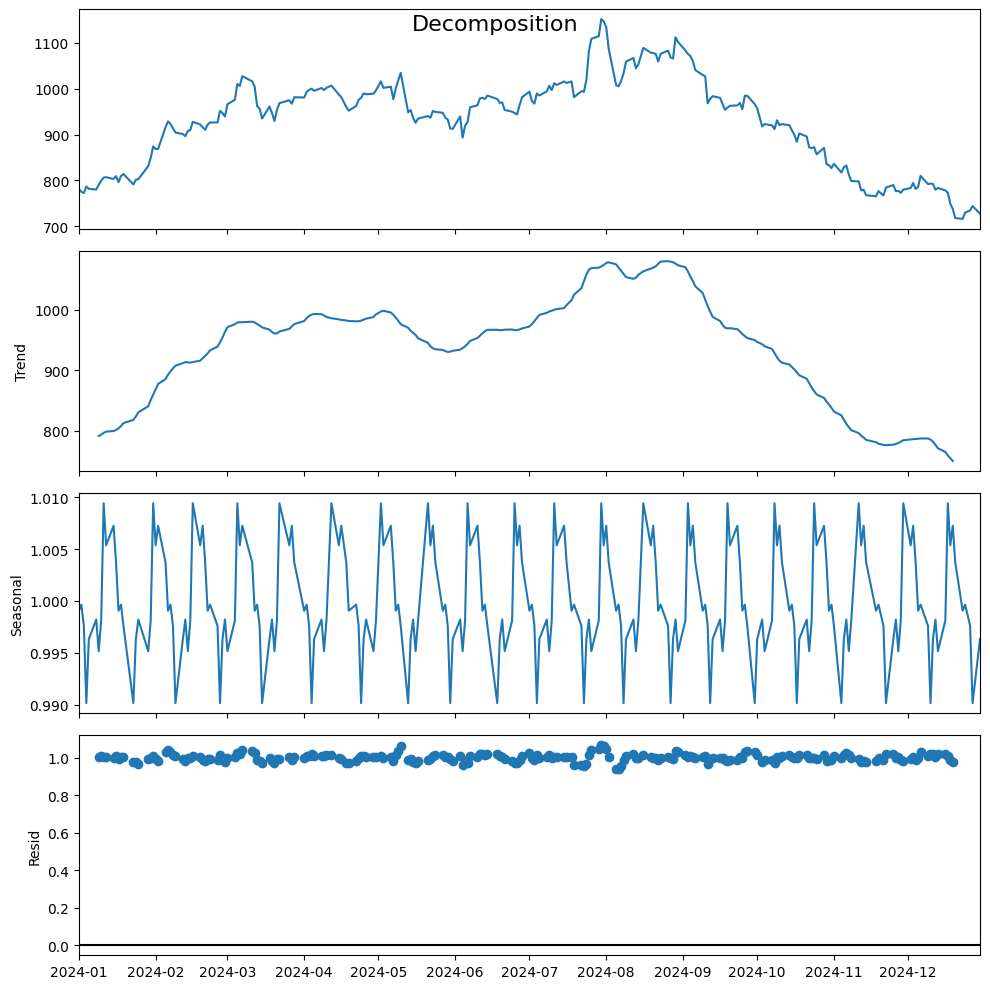

In [6]:
result=seasonal_decompose(data['Close'], model='multiplicative', period=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result.plot()
plt.suptitle('Decomposition', fontsize=16)
plt.show()

In [7]:
adf_result = adfuller(data['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -1.0593993366135355
p-value: 0.7309885625562839


In [8]:
data_diff=data['Close'].diff().dropna()
adf_result2=adfuller(data_diff)
print(f'ADF Statistic: {adf_result2[0]}')
print(f'p-value: {adf_result2[1]}')

ADF Statistic: -14.72365564149162
p-value: 2.7272341596943233e-27


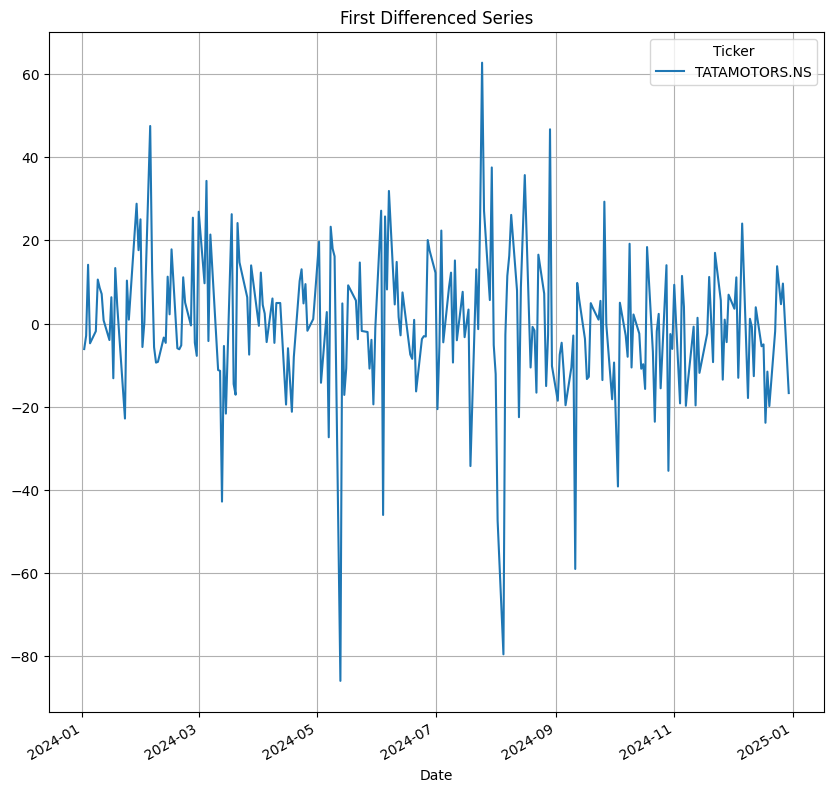

In [9]:
# Plot differenced series
data_diff.plot(title="First Differenced Series")
plt.grid(True)
plt.show()

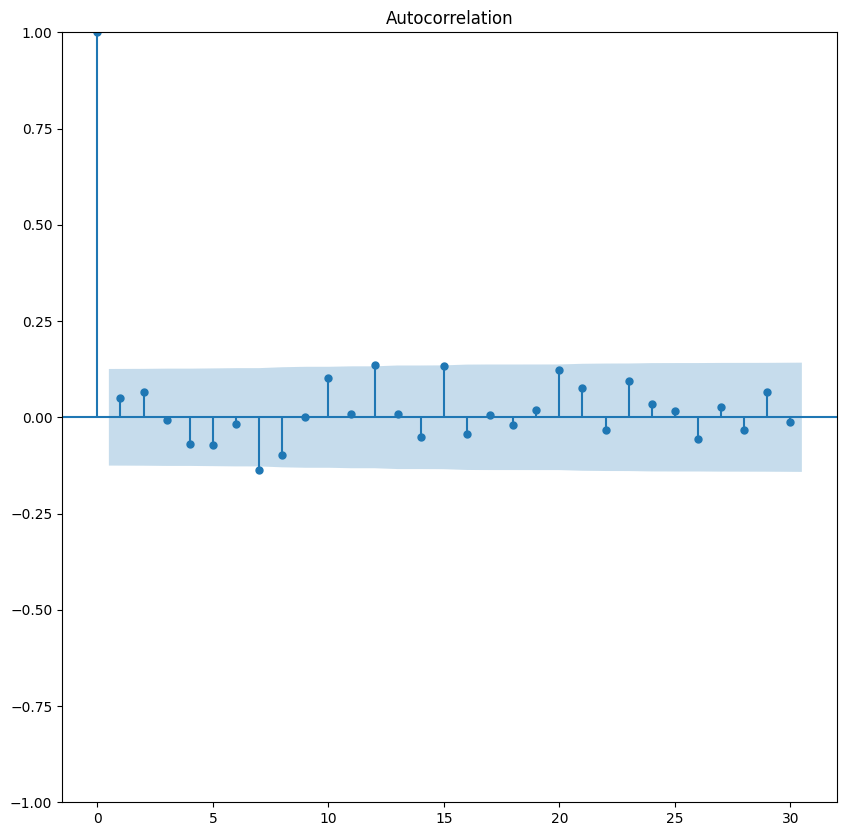

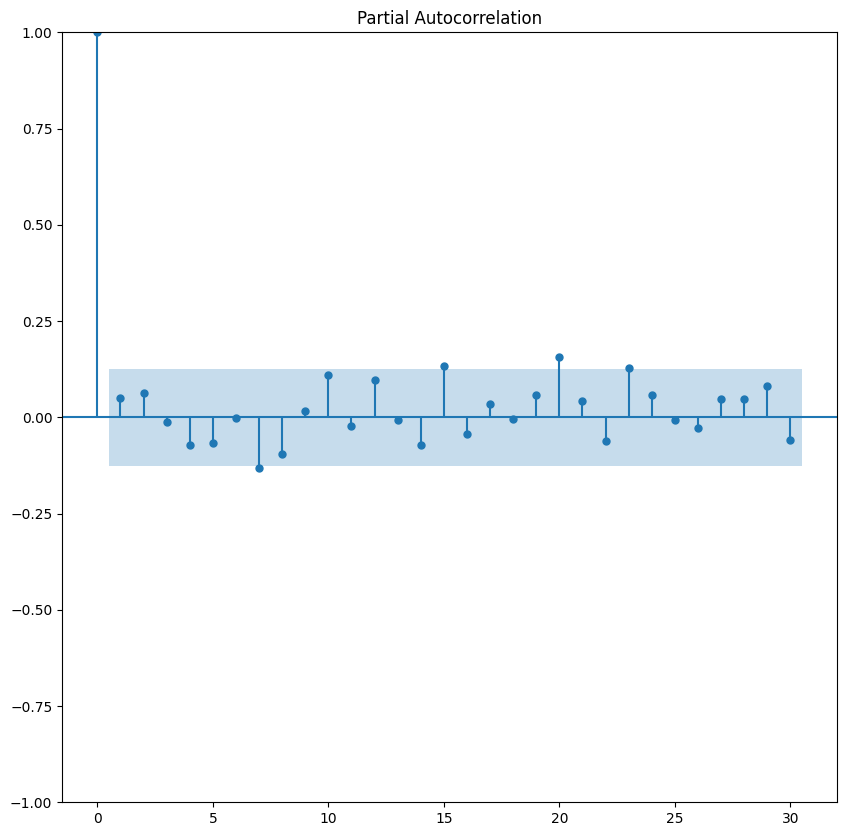

In [10]:
# Plot ACF & PACF
plot_acf(data_diff, lags=30)
plot_pacf(data_diff, lags=30)
plt.show()

In [11]:
# 4. ARIMA Forecasting
# Train-Test Split
train = data[:-30]
test = data[-30:]

In [12]:
# Fit ARIMA model
model = ARIMA(train, order=(2,1,0))  # (p,d,q) can be tuned
model_fit = model.fit()
print(model_fit.summary())

# Forecast
pred = model_fit.forecast(steps=30)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     Close_TATAMOTORS.NS   No. Observations:                  215
Model:                  ARIMA(2, 1, 0)   Log Likelihood                -925.319
Date:                 Sun, 24 Aug 2025   AIC                           1856.638
Time:                         14:30:05   BIC                           1866.736
Sample:                              0   HQIC                          1860.718
                                 - 215                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0536      0.064      0.836      0.403      -0.072       0.179
ar.L2          0.0625      0.078      0.805      0.421      -0.090       0.215
sigma2       333.5853     19.315     17.271 

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [13]:
# Evaluation
mse = mean_squared_error(test, pred)
print(f"ARIMA MSE: {mse:.2f}, RMSE: {np.sqrt(mse):.2f}")

ARIMA MSE: 689.57, RMSE: 26.26


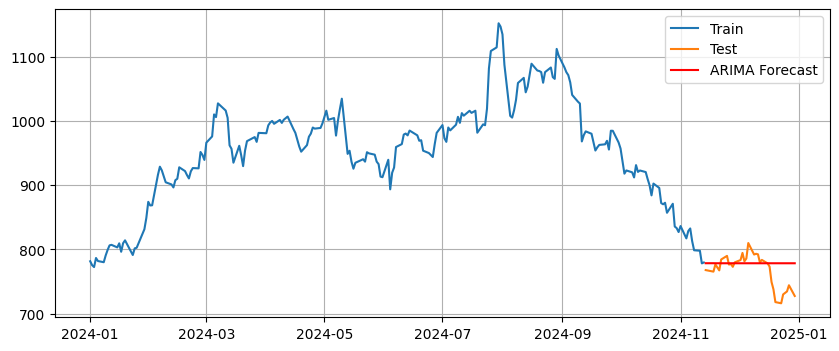

In [14]:
# Plot Forecast
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(test.index, pred, label="ARIMA Forecast", color="red")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# 5. LSTM Forecasting
# Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [16]:
# Prepare Sequences
sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))  # [samples, timesteps, features]

In [17]:
# Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X, y, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.2522
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0349
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0196
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0225
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0180
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0156
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0132
Epoch 8/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0145
Epoch 9/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0166
Epoch 10/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0120
Epoch 11/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0126
Epoch 12/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0121
Epoch 13/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0117
Epoch 14/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0086
Epoch 15/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0096
Epoch 16/20
6/6 ━━━━━━━━━━━━━━━━━━

In [18]:
# Forecast Next 30 Days
n_days = 30
last_sequence = scaled_data[-60:].reshape(1, 60, 1)
predicted = []

for _ in range(n_days):
    next_price = model.predict(last_sequence, verbose=0)[0][0]
    predicted.append(next_price)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_price]]], axis=1)

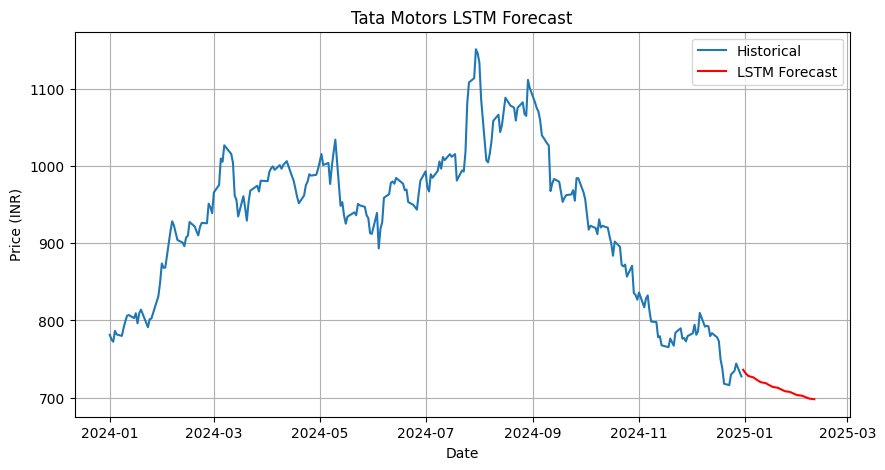

In [19]:
# Inverse Scale
predicted_prices = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

# Plot LSTM Forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Close'], label='Historical')
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_days, freq='B')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast', color='red')
plt.title('Tata Motors LSTM Forecast')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()